# 선형회귀 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [4]:
data_dir = Path('../input/')
trn_file = data_dir / 'train.csv'
seed = 42

In [5]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


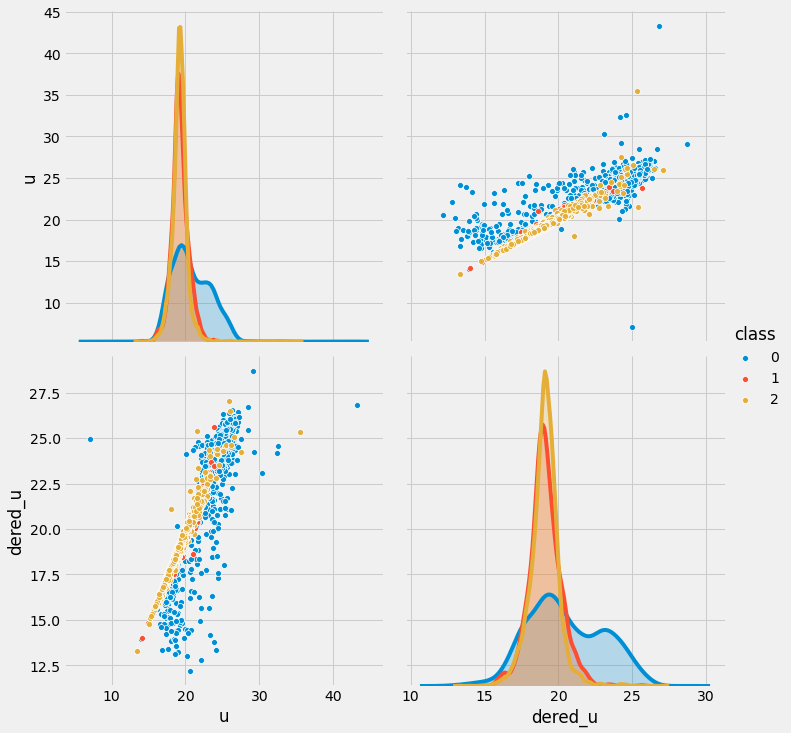

In [6]:
sns.pairplot(trn.sample(n=10000), vars=['u', 'dered_u'], hue='class', size=5)

위 그래프를 통해 `dered_u`와 `u`열 간의 관계는 선형 관계를 띄고 있음을 알 수 있으며, 해당 변수들로 선형회귀 모델 구축 실습을 진행해보겠습니다. 

In [7]:
X = trn[trn['class'] != 0][['u']].values
y = trn[trn['class'] != 0]['dered_u'].values
print(X.shape, y.shape)

(200004, 1) (200004,)


선형회귀 모델 구축 실습을 하기 위해 `u`열을 독립변수 `X`로 설정하고 `dered_u`열을 종속변수 `y`로 설정합니다. 이 때 `class`가 0인 샘플은 제외 합니다. 왜냐하면 시각화 그래프를 봤을 때 0인 경우는 선형관계에서 벗어나 보이므로 이번 실습에서는 0을 제외하고 `class`가 1 또는 2인 샘플만 사용하겠습니다. 

## RMSE 손실함수 정의

In [8]:
rmse = lambda y, p: np.sqrt(np.mean((y - p) ** 2))

앞서 이론을 배울 때에는 손실함수로 MSE를 배워봤습니다. 실습에서는 MSE에 루트(root)를 씌운 RMSE를 손실함수로 정의하겠습니다. RMSE는 종속변수와 스케일이 같아서 값의 의미를 해석하기 용이하기 때문에 자주 사용됩니다. 

파이썬에서 함수를 정의할 때는 `def()`함수를 사용하기도 하지만 위의 예시처럼 `lambda`를 사용해서 정의할 수도 있습니다. `def()`로 위의 함수를 정의하면 아래와 같습니다. 

```
def rmse(y, p):
    return np.sqrt(np.mean((y - p) ** 2))
```

`def()`를 사용하면 두 줄에 거쳐 함수를 정의하지만 `lambda`를 사용하면 간단한 함수인 경우 한 줄로 정의를 내릴 수 있기 때문에 유용하게 사용됩니다. 

## NumPy를 이용한 선형회귀

Numpy를 활용해 선형회귀 모델을 구축해보기 위해 필요한 정보들을 정의하겠습니다. 

In [9]:
alpha = .001
theta0 = .1
theta1 = .1
epoch = 4

`alpha`는 learning rate를 뜻하며 `theta0`는 상수값, `theta1`은 X의 계수를 뜻합니다. `epoch`은 전체 샘플을 활용해 경사하강을 4번 실시하겠다는 의미입니다. 

In [10]:
x = X.flatten()
print(x.shape)

(200004,)


추후 경사하강법을 적용하기 위해 `zip(x, y)`함수를 활용해 독립변수와 종속변수 짝을 지어줘야 하는데, `zip()`함수가 적용되기 위해 차원을 맞춰주는 작업입니다. X가 기존에는 2차원 array였는데 1차원으로 변경된 것을 알 수 있습니다. 

In [11]:
rmses = []
for i in tqdm(range(epoch)):
    for x_i, y_i in zip(x, y):
        p_i =  theta0 + theta1 * x_i
        theta0 = theta0 + alpha * (y_i - p_i)
        theta1 = theta1 + alpha * (y_i - p_i) * x_i
    rmses.append(rmse(y, theta0 + theta1 * x))

위 코드는 경사하강법을 구현한 코드입니다. 먼저 `p_i`에 현재의 `theta0`와 `theta1`을 활용해 예측값을 구합니다. 그리고 나서 각 `theta`는 미분한 식에 `alpha`를 곱해서 업데이트를 해줍니다. 

In [12]:
theta1, theta0

(0.9362306162023849, 1.1088813148478316)

4번의 `epoch`을 통해 계수가 업데이트 된 결과가 위와 같음을 알 수 있습니다. 

In [13]:
rmses

[0.25618215910731906,
 0.25492967552380746,
 0.25461791287963526,
 0.25454708923095914]

또한 손실함수인 RMSE가 `epoch`이 진행될 때 마다 조금씩 줄어든 것을 확인할 수 있습니다. 

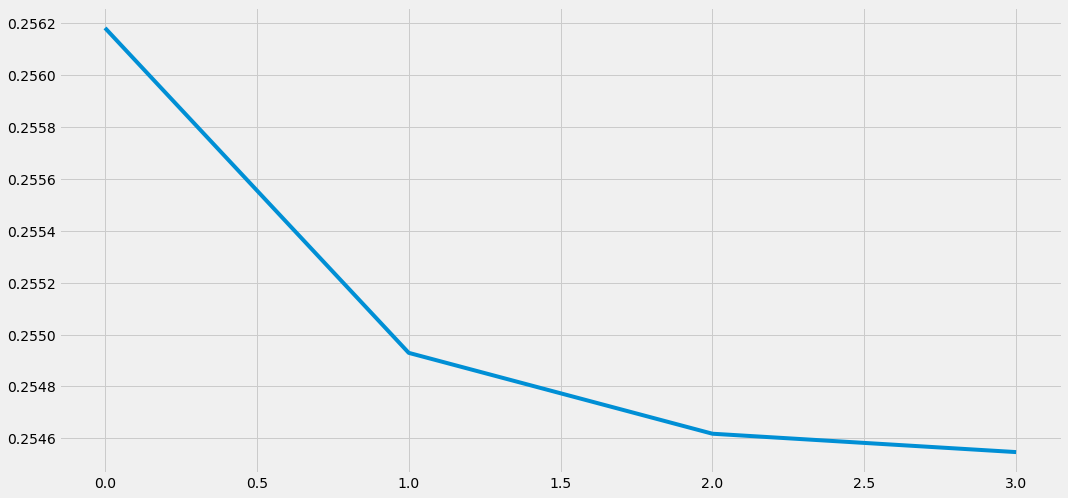

In [14]:
plt.plot(rmses)

`rmses`를 시각화 해서 보면 위의 그래프와 같습니다. `epoch`진행될 수록 손실함수 값이 점점 줄어든 것을 확인할 수 있으며, 모델의 성능이 점점 좋아졌음을 알 수 있습니다. 

Text(0, 0.5, 'dered_u')

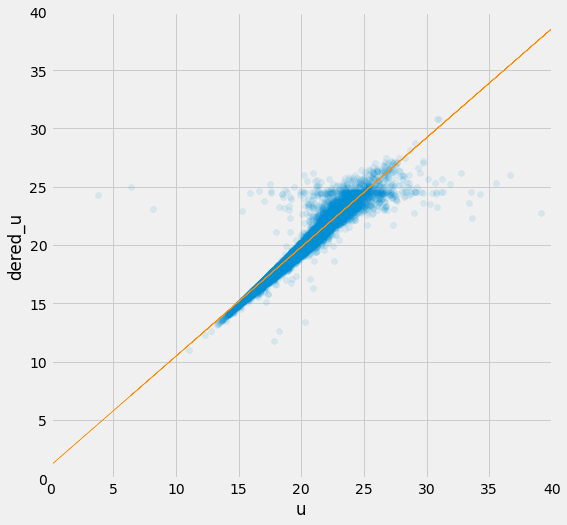

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=.1)
plt.plot(X, theta0 + theta1 * x, color='darkorange', linewidth=.5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

실제값과 모델의 예측값을 그래프로 그려보면 위와 같습니다. 파란 점들은 실제값을 나타내며 주황색 선은 경사하강법을 통해 학습한 선형회귀 모델이 예측한 값입니다. 꽤 정확하게 예측하고 있음을 확인할 수 있습니다. 

## scikit-learn을 이용한 선형회귀

실제 분석을 할 시에는 numpy로 경사하강법을 직접 구현할 필요는 없습니다. scikit-learn 라이브러리에서 제공하는 함수를 활용해 2~3줄만에 쉽게 선형회귀 모델을 구축할 수 있기 때문입니다. 

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
p = lr.predict(X)

`sklearn.linear_model` 모듈 내에 있는 `LinearRegression`함수를 가지고와서 `lr`변수에 선형회귀 모델 객체를 생성해준 후 `fit()`명령어에 독립변수와 종속변수를 입력해서 선형회귀 모델을 학습시켜 줍니다. 그리고 `predict()`함수를 통해 예측을 해서 예측값을 `p`변수에 저장해줍니다. 

In [17]:
rmse(y, p)

0.2522450693360897

예측한값과 실제값과의 rmse가 0.2522가 나온것을 확인할 수 있습니다. numpy로 직접구현해서 4번의 epoch동안 경사하강법을 적용했을 때는 rmse가 0.2545가 나왔는데, scikit-learn으로 학습을 하니 단번에 rmse가 더 줄어든 것을 확인할 수 있습니다. 

In [18]:
lr.coef_, lr.intercept_

(array([0.9320425]), 1.1556424178625342)

`lr.coef_`와 `lr.intercept_`를 사용해 학습된 계수를 확인해보니 numpy로 학습했을 때의 계수와 유사한 것을 확인할 수 있습니다. 

Text(0, 0.5, 'dered_u')

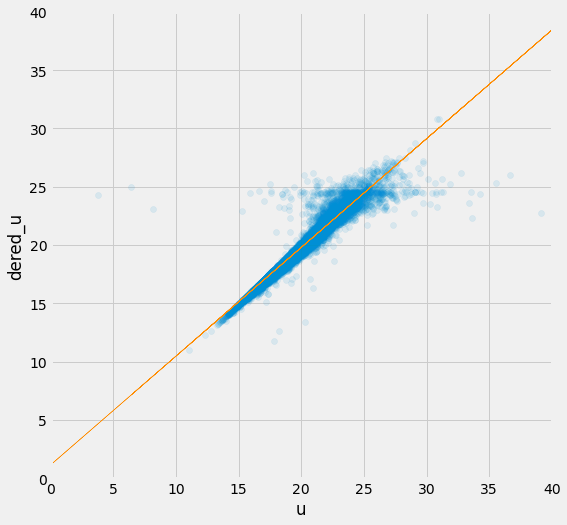

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(X, y, alpha=.1)
plt.plot(X, p, color='darkorange', linewidth=.5)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.xlabel('u')
plt.ylabel('dered_u')

마찬가지로 위의 그래프는 scikit-learn으로 학습한 선형회귀 모델의 예측값이 주황색으로 표시된 그래프입니다. 

## scikit-learn을 이용한 로지스틱회귀

In [38]:
X = trn[trn['class'] != 0].drop('class', axis=1)
y = trn[trn['class'] != 0]['class'].values - 1

scikit-learn을 활용해 로지스틱회귀 모델을 구축하기 위해 간단한 데이터 처리를 먼저 진행하겠습니다. 현재 `class`에는 3개의 범주 (0, 1, 2)가 존재합니다. 이번 실습에서는 간단한 이진 분류 문제로 변형하기 위해 0인 `class`를 제외한 데이터만으로 실습을 진행해보겠습니다. 

`class`를 제외한 모든 변수를 독립변수 `X`에 저장하고 `class`는 종속변수 `y`에 저장합니다. 0을 제외하면 `class`에는 1과 2가 남게 됨으로 `y`변수에는 1과 2만 존재합니다. 해당 범주를 0과 1로 변형하기 위해서 1을 빼줍니다. 

In [22]:
np.unique(y)

array([0, 1])

1을 빼줘서 `class`를 0과 1로 만들어 주었기 때문에 `y`에 존재하는 고윳값을 `np.unique()`함수를 통해 확인해보면 0과 1만 있음을 알 수 있습니다. 

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

lr = LogisticRegression()
lr.fit(X, y)
p = lr.predict_proba(X)[:, 1]

`sklearn.linear_model` 모듈에서 `LogisticRegression`함수를 불러오고 `sklearn.metrics`에서 `log_loss`와 `roc_auc_score`함수를 불러옵니다. `log_loss`는 로지스틱회귀를 학습/평가할 때 사용하는 손실함수이며 `roc_auc_score`는 분류 모델의 성능을 측정할 때 사용하는 대표적인 지표입니다. 

로지스틱회귀 모델을 학습하기 위해 `LogisticRegression()`객체를 `lr`변수에 저장하고 `fit()`함수에 독립변수와 종속변수를 입력해 모델을 학습합니다. 

범주형 모델로 예측을 수행하기 위해선 `predict()` 또는 `predict_proba()`를 사용할 수 있습니다. `predict()`함수는 0 또는 1의 범주를 반환하며 `predict_proba()`는 각 범주에 속할 확률을 반환니다. `proba`는 probability(확률)의 약자입니다. 

`predict_proba()`실행하면 n행 2열로 된 2차원의 배열이 반환됩니다. n은 입력값 X의 행의 개수와 같으며 열이 2개인 경우는 이번 실습에서 사용한 범주의 개수가 2개이기 때문입니다. 첫번째 열은 범주 0에 속할 확률이며 두번째 열은 범주 1에 속할 확률이 저장돼있습니다. 그 중 두번째 열에 있는 확률 값을 선택해 `p`변수에 저장합니다. 

In [42]:
lr.coef_, lr.intercept_

(array([[ 0.81266917,  0.08317138, -1.87245322,  0.51565384, -0.54844623,
         -1.58805578,  2.26069235, -0.05486364, -1.36138002,  0.57936571,
         -0.59896011,  0.08585678, -0.10280546, -0.14195166, -0.1445912 ,
         -0.13945722, -0.14068748, -0.14325409]]),
 array([0.22177582]))

로지스틱 회귀 모델의 학습된 계수를 위의 명령어를 통해 확인할 수 있습니다. 

In [40]:
log_loss(y, p)

0.3656496250562368

In [41]:
roc_auc_score(y, p)

0.8761459752003657

In [43]:
from kaggler.metrics import plot_roc_curve, plot_pr_curve

아래는 `kaggler`라이브러리에서 제공하는 함수를 활용해 auc curve와 precision-recall curve를 그리는 과정입니다. 해당 그래프는 분류모델의 성능을 평가시 자주 사용하는 그래프입니다. 

Text(0.5, 1.0, 'Precision-Recall Curve')

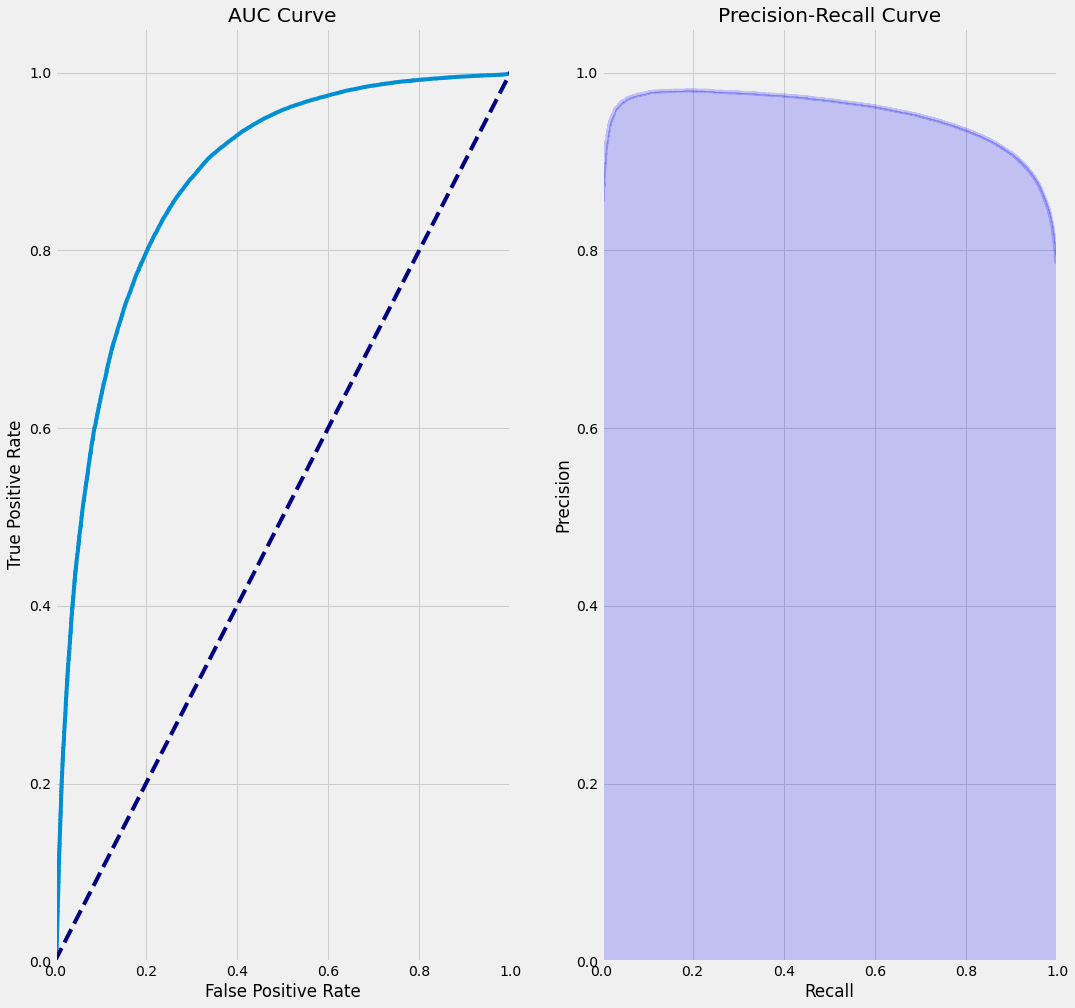

In [46]:
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plot_roc_curve(y, p);
plt.title('AUC Curve')
plt.subplot(1, 2, 2)
plot_pr_curve(y, p);
plt.title('Precision-Recall Curve')